Authors: Leonardo De Clara, Riccardo Sena

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm,rv_discrete, invgamma

# ***Assignment 4***
Welcome to Assignment 4! In this assignment you are allowed to work 
***individually or in pairs***. It is worth 25 points in total. 

### ***Difference in this assignment***
You have two options: **either** you implement
1.   PyClone, or
2.   Particle Gibbs with Ancestral Sampling

**You are only allowed to do one of the above**. They are worth 25 points each. As usual, there is a 5 point minimum for passing this assignment (you need to pass all four assignments to be able to pass the course, see the grade chart on the Canvas course page for more details).

Submission details: Your submission should contain two pdf's. 

1. A pdf version of your filled out colaboratory on Canvas. You can do this by pressing `cmd/ctrl+p` (you know the drill from there).  
2. For Exercise 1, you need to hand in your hand-written solutions in a LaTeX pdf. We only accept solutions written in LaTeX, i.e. not Word or any other text editor. We recommend [Overleaf](https://overleaf.com), if you do not already have a favourite LaTeX editor (which is also [provided by KTH](https://intra.kth.se/en/it/programvara-o-system/programvara/installera/download/overleaf/overleaf-1.932755)).

# ***2. Particle Gibbs with Ancestral Sampling***

**Relevant resources:**

*   Andrieu, Christophe, Arnaud Doucet, and Roman Holenstein. "[Particle markov chain monte carlo methods.](https://www.stats.ox.ac.uk/~doucet/andrieu_doucet_holenstein_PMCMC.pdf)" Journal of the Royal Statistical Society: Series B (Statistical Methodology) 72.3 (2010): 269-342.
*   Lindsten, Fredrik, Michael I. Jordan, and Thomas B. Schon. "[Particle Gibbs with ancestor sampling.](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" Journal of Machine Learning Research 15 (2014): 2145-2184.
*   Uppsala university's SMC course (see our lecture slides for refences).
*   Our lecture slides available on Canvas.


This is a follow-up task from Assigment 3. If you implemented the BPF, you will be able to reuse code from the last assignment (**if you did not implement the BPF before, you get the chance to implement it here instead**). There you were asked to find the parameters, $\theta$, that most likely generated the observations, $y_{1:T}$, by evaluating $p(y_{1:T}|\theta)$ for different choices of $\theta$ (recall the grid search).

Here you will learn a more elegant method for inferring probable parameters: via a combination of particle filtering and MCMC, hence termed PMCMC. This approach was first proposed by Andrieu et al. (in the first item above). You are asked to first implement the particle Gibbs (PG) method, which we discussed in the lectures, and then augment it using "ancestor sampling" (proposed in the second item). Throughout the assignment we will continue to work with the stochastic volatility (SV) model from the previous assignment, included here for completeness:

### **SV Model**
$$\begin{equation*}
        x_1 \sim \mathcal{N}(0, \frac{\sigma^2}{1 - \alpha ^2}),
\end{equation*}$$

$$\begin{equation*}
        x_n \sim \mathcal{N}(\alpha x_{n-1}, \sigma^2),
\end{equation*}$$

$$\begin{equation*}
        y_n \sim \mathcal{N}(0,  \beta^2\exp(x_{n})),
\end{equation*}$$

for $n=1,...,T$. We will assume that the parameters $\beta$ and $\sigma^2$ are unknown, while we assume that $\alpha=0.91$.

## **Conjugate priors**
We place inverse Gamma priors on the variance parameters:

\begin{align}
\sigma^2 & \sim \mathcal{IG}(a=0.01,b=0.01),
\\
\beta & \sim \mathcal{IG}(a=0.01,b=0.01),
\end{align}


where the the inverse Gamma pdf with parameters $(a,b)$ is given by
\begin{equation}
\mathcal{IG}(x|a,b)=\frac{b^a}{\Gamma(a)} x^{-a-1} \exp\left(-\frac{b}{x}\right)
\end{equation}
and $\Gamma$ is the Gamma function.

These priors are conjugate to the corresponding SV model pdf's and yield the following posteriors
\begin{equation}
    p(\sigma^2|x_{1:T}, \alpha) = \mathcal{IG}\left(\sigma^2|a + \frac{T}{2}, b + \frac{x_1^2(1 - \alpha^2)}{2} + \frac{1}{2}\sum^{T}_{n=2} (x_n - \alpha x_{n-1})^2\right),
\end{equation}

\begin{equation}
    p(\beta|x_{1:T}, y_{1:T}) = \mathcal{IG}\left(\beta|a + \frac{T}{2}, b + \frac{1}{2} \sum^T_{n=1}e^{-x_n}y_n^2\right)
\end{equation}

## **2.1 Implement the Particle Gibbs**
Implement a particle Gibbs sampler to compute the posterior distribution $p(\sigma^2,\beta|\alpha,y_{1:T})$. To do so, alternately sample from

*  $p(\sigma^2|\alpha,x_{1:T})$,
*  $p(\beta|x_{1:T},y_{1:T})$,
*  $p(x_{1:T}|\theta,y_{1:T})$ using conditional SMC.

To recall what a conditional SMC is, have a look at the SMC lecture slides (lecture 7 specifically), or the other resources.

Use a bootstrap particle filter (BPF) and resample at every iteration. Use the multinomial resampling scheme. **Hint:** read what you need to report as stated below, before you start coding.


In [2]:
class proposal(sp.stats.rv_continuous):
    def __init__(self, alpha, sigma):
        super().__init__()
        self.alpha = alpha
        self.sigma = sigma
       
    def pdf(self, x, x_prev):
        return norm.pdf(x, loc=self.alpha*x_prev, scale=self.sigma)
    
    def sample(self, x, size):
        return np.random.normal(self.alpha*x,self.sigma,size=size)
    
class emission(sp.stats.rv_continuous):
    def __init__(self, beta):
        super().__init__()
        self.mean = 0
        self.beta = beta
       
    def pdf(self,y,x):
        return norm.pdf(y, loc=self.mean, scale=self.beta*np.exp(x/2))
    
    def sample(self, x, size):
        return np.random.normal(self.mean,self.beta*np.exp(x/2),size=size)


def multinomial(weights, K, N):
    return np.random.choice(K, N, p = weights)

       
def beta_post(a, b, x1, y1):
    p1 = a + len(x1)/2
    sum = 0
    #for s in range(len(x1)):
    #    sum += np.exp(-x1[s])*(y1[s]**2)
    sum = np.sum(np.exp(-x1)*(y1**2))
    p2 = (b + 0.5 * sum)
    var = invgamma.rvs(p1, scale=p2, size = 1)
    x = np.linspace(0, 10, 100)
    
    return var
    
def sample_particle(particles, weights):
    cat_dist = rv_discrete(name='categorical', values=(particles,weights))
    return cat_dist.rvs(size=1)[0]
       

def sigma_post(a, b, alpha_p, x2):
    param1 = a + len(x2)/2
    sum2 = 0
    for s in range(1, len(x2)):
        sum2 = sum2 + (x2[s] - alpha_p*x2[s-1])**2
    #np.sum((x[1:len(x)]-alpha_p*x[0:(len(x)-1)])**2)
    param2 = (b + 0.5 * (x2[0]**2)*(1-(alpha_p**2)) + 0.5 * sum2)
    var2 = invgamma.rvs(param1, scale=param2, size=1)
    
    return var2

def prior(a,b):
    dist = invgamma(a,b)
    return dist.rvs(size=1)

In [3]:
def bpf(K, T, alpha_param, sigma_param, beta_param, y_true, resampling_scheme):

    proposal_dist = proposal(alpha_param,sigma_param)
    emission_dist = emission(beta_param)

    x_n_hat_after = np.zeros(T)

    x1 = np.zeros((T,K))
    x_old = np.zeros((T,K))
    w = np.zeros((T,K))
    w_normalized = np.zeros((T,K))

    x1[0,:] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)),K) # Initialize the particles
    x_old[0,:] = x1[0,:]

    w[0,:] = emission_dist.pdf(y_true[0],x1[0,:]) # Compute the weights at t = 0
    w_normalized[0,:] = w[0,:]/np.sum(w[0,:])
    a = np.zeros(K)


    for i in range(1,T):

        a = resampling_scheme(w_normalized[i-1,:], K,K)

        # Sample the particles
        x1[i,:] = proposal_dist.sample(x1[i-1,a],K)

        x_old[i-1,:] = x1[i-1,a]
        x1[0:i-1,:] = x1[0:i-1,a]
        # Compute the weights
        w[i,:] = emission_dist.pdf(y_true[i],x1[i,:])
        # normalize the weights
        w_normalized[i,:] = w[i,:]/np.sum(w[i,:])
        x_n_hat_after[i] = np.sum(w_normalized[i,:]*x1[i,:])
 
    return x1, w, w_normalized, x_n_hat_after, x_old

In [4]:
def conditional_smc(K, T, alpha_param, sigma_param, beta_param, y_true, x_ref, resampling_scheme):
    """Conditional SMC algorithm"""

    proposal_dist = proposal(alpha_param,np.sqrt(sigma_param))
    emission_dist = emission(beta_param)
    x = np.zeros((T,K))
    w = np.zeros((T,K))
    w_normalized = np.zeros((T,K))

    x_n_hat_after = np.zeros(T)

    # set one particle as the reference
    x[0,K-1] = x_ref[0]

    x[0,0:(K-1)] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)), K-1) # Initialize the particles

    # here might need to set all the weights to 1/K
    w[0,:] = emission_dist.pdf(y_true[0],x[0,:]) # Compute the weights at t = 0
    # w[0,:] = np.ones(K)
    w_normalized[0,:] = w[0,:]/np.sum(w[0,:])
    a = np.zeros(K-1)

    for i in range(1,T):

        #Resample the particles, apart from the reference one
        a = resampling_scheme(w_normalized[i-1,:], K, K-1)
        x[i,0:(K-1)] = proposal_dist.sample(x[i-1,a],K-1) # Sample the particles
        x[i,K-1] = x_ref[i]
        x[0:i-1,0:(K-1)] = x[0:i-1,a]

        # w[i-1,a[k]]=1, so the new weights are just equal to the alphas
        # Compute the weights
        w[i,:] = emission_dist.pdf(y_true[i],x[i,:])

        # normalize the weights
        w_normalized[i,:] = w[i,:]/np.sum(w[i,:])
        x_n_hat_after[i] = np.sum(w_normalized[i,:]*x[i,:])

    
    final = resampling_scheme(w_normalized[T-1,:], K, 1)

    return np.reshape(x[:,final], (T,)), x, x_n_hat_after

In [5]:
def pg(M, T, K, alpha_p, y, a, b):
    """Particle Gibbs algorithm
    M: number of iterations of Particle Gibbs
    T: number of time steps
    K: number of particles
    alpha_p: parameter of the proposal distribution for the particles
    y: observations
    a: parameter of the prior distribution for beta and sigma
    b: parameter of the prior distribution for beta and sigma
    """

    x_r = np.zeros((T,M)) # one T-long trajectory for each of the M steps of the algorithm

    betas = np.zeros(M)
    sigmas = np.zeros(M)

    betas[0] = 0.1
    sigmas[0] = 0.1

    #bpf to get the first trajectory to use as reference
    particles, _, weights_normalized, _, _ = bpf(K, T, alpha_p, sigmas[0], betas[0], y, multinomial)
    index = multinomial(weights_normalized[T-1,:], K, 1)
    x_r[:,0] = np.reshape(particles[:,index], (T,))
    
    for m in range(1,M):
        plt.plot(x_r[:,m-1], label = "it "+str(m-1))
        plt.legend()
    
        #Sampling the parameters from their posterior
        betas[m] = beta_post(a, b, x_r[:,m-1], y)
        sigmas[m] = sigma_post(a, b, alpha_p, x_r[:,m-1])

        print("Beta is: ", betas[m])
        print("Sigma is: ", sigmas[m])

        #Sampling the particles using conditional SMC
        x_r[:,m],__,__ = conditional_smc(K, T, alpha_p, sigmas[m], betas[m], y, x_r[:,m-1], multinomial)
        print("Trajectory is: ", x_r[:,m])
        #plt.plot(x_r[:,m])
    
        
    return x_r, betas, sigmas


Beta is:  0.13402348334620542
Sigma is:  0.10784230671297897
Trajectory is:  [ 0.40440543  0.8759832   0.42189307 -0.46790524  1.05083905  1.20714155
  0.97134886  1.10255638  1.32543792  2.5516793   2.55752467  1.81692665
  2.26996699  1.13982367  0.97731546  1.92646346  1.68561029  0.82106577
  1.70884874  1.15025229  0.73027761  2.51224128  0.37458364  2.69590373
  2.10711469  1.58832141  0.93459507  2.18618248  1.88648666  1.35263327
  2.13759952  2.07875808  0.26627229  1.73995741  1.56892187  2.09662324
  2.37004509  2.46831823  2.6075819   2.3290736   1.70425273  1.4021155
  2.07893511  2.81172087  0.49570733  1.58420111  0.48088108  2.93353378
  1.59941256  1.90200276  1.77133393  1.02660825  1.22492338  1.10157206
  0.70841855  1.30467613  1.26100565 -0.19424119  2.49701684  2.00286433
  2.62206332  2.25142264  1.43207985  1.3012721   1.52476017  2.11862569
  1.7794428   1.46328685  1.48316257  0.62199756  0.70510419  2.14408272
  3.12823421  2.41792248  1.85341914  2.46420522

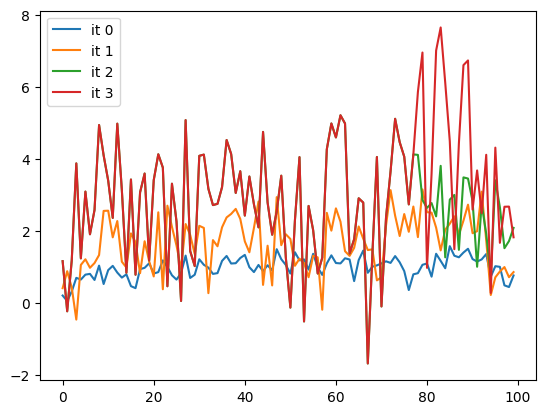

In [8]:
# load observations.npy from the SMC module on Canvas
observations = np.load('observations.npy')
M = 5
K = 100
T = 100
a = 0.01
b = 0.01
alph = 0.91
sigm = 0.9


x_ref, betas, sigmas = pg(M, T, K, alph, observations, a, b)

## **Report the distributions $p(\sigma^2|\alpha,x_{1:T})$ and $p(\beta^2 |x_{1:T},y_{1:T})$**
Use a trace plot to show that the PG has converged, and histograms to visualize the two distributions. Remember to discard the burn-in samples. If you did Assignment 3, how do these distributions correspond to your findings from the grid search? (You will not get point deduction if you have not done the grid search in assignment 3!) 

## **Report the approximate marginal likelihood**
From the lecture slides, we know how to compute the following marginal likelihood

\begin{equation}
p(y_{1:T}|\theta) = \int_{x_{1:T}} p(y_{1:T}|x_{1:T}, \theta) p(x_{1:T}|\theta) dx_{1:T} \approx \prod_{i=1}^T \sum_k\frac{1}{K} p(y_i|x_i^k, \theta).
\end{equation}

Use the PG sampler to compute the marginal likelihood, averaged over your MCMC iterations.

**Motivate why this is an approximation of the marginal likelhood, $p(y_{1:T})$. How is $p(y_{1:T})$ different from $p(y_{1:T}|\theta)$?**



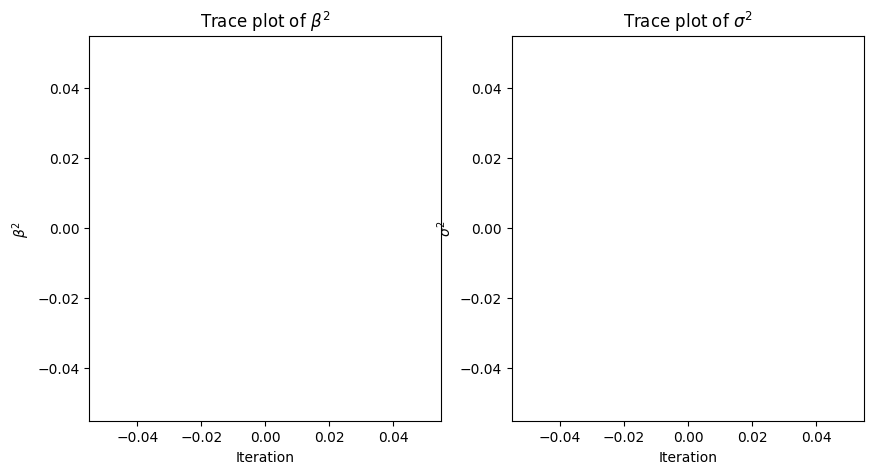

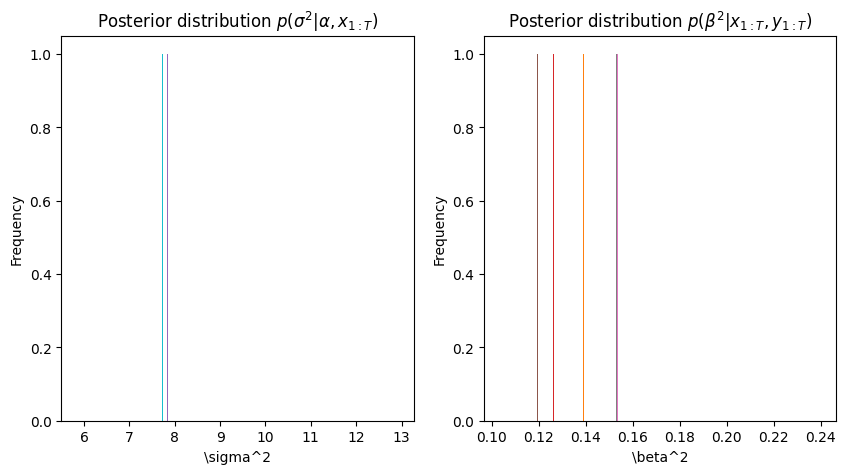

In [10]:
burn_in = int(0.3*T)

betas = betas[burn_in:]
sigmas = sigmas[burn_in:]

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(betas)
axs[0].set_title('Trace plot of $\\beta^2$')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('$\\beta^2$')
axs[1].plot(sigmas)
axs[1].set_title('Trace plot of $\\sigma^2$')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('$\\sigma^2$')
plt.show()

#Sigma and beta posterior distributions
num_samples=100
sigma_samples = [sigma_post(a, b, alph, x_ref[:,-1]) for _ in range(100)]
beta_samples = [beta_post(a, b, x_ref[:,-1], observations) for _ in range(100)]

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].hist(sigma_samples, bins=100)
axs[0].set_title('Posterior distribution $p(\sigma^2|\\alpha,x_{1:T})$')
axs[0].set_xlabel('$\sigma^2$')
axs[0].set_ylabel('Frequency')
axs[1].hist(beta_samples,bins=100)
axs[1].set_title('Posterior distribution $p(\\beta^2 |x_{1:T},y_{1:T})$')
axs[1].set_xlabel('$\\beta^2$')
axs[1].set_ylabel('Frequency')
plt.show()


In [ ]:
#Approximate marginal likelihood

*Answer here*

## **Visualize the path degeneracy**
Using the particle filter from the final MCMC iteration, plot the path degeneracy in the particle filter. Below we provide some code to help you visualize the path degeneracy. 

**Hint:** when you code your BPF, make sure to keep track of the ancestry and the inferred latent states at each time step. I.e. at each time step $n$, book keep the ancestors of the particles in the system, $k$ or $a^k$, and their corresponding $x_n$. This way you can go "backwards in time" and observe the path degeneracy.

In [ ]:
def particleGeneologyAll(title, particles, B, x_true=None, x_rs=None): 
    # particle: the inferred latent states at each time step shape=(num_particles, total_time)
    # B: the complete ancestry shape=(num_particles, total_time)  
    plt.figure(figsize=(14, 8)) 
    N, T = particles.shape 
    x_matrix = np.arange(T)

    # plot all the particles first
    for j in range(N): 
        plt.scatter(x_matrix, particles[j], color="lightgrey", s=5) 
     
    # plot geneology of survived 
    x_star = np.zeros(T) 
    for j in range(N): 
        curr = j 
        i = T-1 
        x_star[i] = particles[j, T-1] 
        for t in reversed(range(T-1)): 
            if curr == N - 1 and j != N - 1: 
                # Originated from reference particle 
                break 
            indx = B[curr, t+1] 
            x_star[i-1] = particles[indx, t] 
            curr = indx 
            i -= 1 
        x_dim = range(t, T) 
         
        if j == N - 1 and x_rs is None: 
            plt.plot(x_dim, x_star, color='blue', linewidth=3) 
        else: 
            plt.plot(x_dim, x_star[t:], color='black', marker='.', markersize=5, lw=1,
                    alpha=0.8, antialiased=True)
     
    if x_rs is not None: 
        for t, resampled, original in zip(range(T), x_rs[0], x_rs[1]): 
            plt.plot((t-1, t), (resampled, original), color='blue', linewidth=3)
     
    if x_true is not None:  
        plt.plot(x_true, color='g', linewidth=3) 
     
    plt.title(title) 
    plt.ylabel('Volatility') 
    plt.xlabel('t') 
    plt.show() 

## **2.2 Implement the Particle Gibbs with Ancestral Sampling (PGAS)**
In "[Particle Gibbs with ancestor sampling](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" they point out that the resulting particle system in the PG sampler is undesirably biased towards the reference trajectory. This affects the path degeneracy in the way that most particles are resampled from the reference trajectory.

PGAS is a relatively small update of the PG sampler but comes with great benefits in terms of path degeneracy. Update your PG sampler above into the PGAS, repeat the following two exercises:

*   **Report the approximate marginal likelihood**
*   **Visualize the path degeneracy**



TODO: could add autocorrelation function plots for PG vs PGAS